# Esercitazione 4 - Simulazione di dinamica molecolare (Verlet algorithm)

## 1 Obiettivo

L'obiettivo dell'esercitazione è quello di eseguire delle simulazioni di dinamica molecolare realizzate implementando l'algoritmo di Verlet.
Gli esercizi proposti richiedono di modificare un codice fornitoci apportando alcune migliorie, per poi utilizzare il prodotto finale per la simulazione di uno specifico sistema.

## 2 Cenni teorici e metodologie

Il codice utilizzato in questa esercitazione realizza una simulazione di dinamica molecolare basata sulla risoluzione delle equazioni del moto.

Il potenziale di interazione tra le particelle è il potenziale di Lennard-Jones 

$$
U(r) = 4\epsilon[(\sigma/r)^{12}-(\sigma/r)^6]
$$

in questa simulazione viene applicato un cut-off sferico al potenziale. Vale a dire che le particelle a distanza $r>r_c$ vengono considerate non interagenti. $r_c$ è un parametro della simulazione. 

Il sistema che si vuole studiare viene preparato in uno stato iniziale, inizia poi la fase di equilibrazione in cui si lascia evolvere fino a quando non raggiunge l'equilibrio, identificabile dal fatto che le grandezze fisiche misurate fluttuano intorno a valori fissi.
Conclusa l'equilibrazione del sistema è possibile effettuare la fase di misura. Come in un reale esperimento è importante eseguire diverse misure, da cui poi estrapolare valore medio e incertezza, in modo da limitare gli errori dovuti a fluttuazioni statistiche.

L'evoluzione del sistema viene effettuata per tempi discreti integrando numericamente le equazioni del moto. Ovvero, nota la configurazione al tempo $t$ si esegue uno step dell'algoritmo di Verlet che permette di simulare l'evoluzione del sistema al tempo $t+\delta t$. L'intervallo $\delta t$ è chiamato "time step" dell'integrazione.  

L'algoritmo di Verlet si basa su uno sviluppo in serie di Taylor al terz'ordine delle equazioni del moto fornendo la seguente formula per un passo dell'integrazione:
$$
\vec r_i(t+\delta t) = 2\vec r_i(t)-\vec r_i(t-\delta t) + \delta t^2 \vec f_i/m_i
$$
dove $\vec f_i$ rappresenta la forza agente sulla particella i-esima. Questo algoritmo ha alcune interessanti proprietà:
- è simmetrico per inversione temporale e quindi incline ad una migliore conservazione dell'energia anche per time steps ($\delta t$) molto lunghi
- richiede una sola valutazione della forza per ciascuno step rendendolo adatto anche ad applicazioni in cui questa operazione risulti computazionalmente costosa
- ciascuno step di integrazione richiede la configurazione del sistema sia al tempo $t$ sia al tempo $t-\delta t$. Questo rende l'algoritmo incapace di iniziare la simulazione conoscendo soltanto la configurazione iniziale.
- non fa uso delle velocità. Queste possono essere calcolate approssimandole entro l'ordine $\delta t^2$ con il rapporto finito 
$$\vec v_i \simeq\frac{\vec r_i(t-\delta t)-\vec r_i(t+\delta t)}{2\delta t}$$

La temperatura viene calcolata utilizzando la seguente relazione con l'energia cinetica
$$ 2\langle K \rangle = 3Nk_BT $$

## 3 Implementazione

Nel codice utilizzato viene simulata l'evoluzione delle particelle all'interno di un box cubico di dimensioni finite. L'obiettivo della simulazione è lo studio delle proprietà di bulk del sistema, vengono quindi implementate condizioni al contorno periodiche. Su scale più piccole delle dimensioni del box le proprietà simulate sono analoghe a quelle di un sistema di dimensione infinita.

Per rendere più semplice la fase di equilibrazione è stata implementata la possibilità di riprendere l'esecuzione di una simulazione precedente avendo salvato le configurazioni ai tempi finali $t$ e $t-\delta t$. In questo caso gli step che vengono eseguiti sono i seguenti:
- viene calcolata la configurazione a $t+\delta t$ con l'algoritmo di Verlet
- vengono stimate le velocità al tempo $t$
- vengono riscalate le velocità in accordo con la temperatura alla quale si vuole simulare il sistema
- con le nuove velocità viene ricalcolata la configurazione al tempo $t-\delta t$

Le misure delle grandezze fisiche oggetto di indagine vengono eseguite ogni 10 steps di integrazione. I valori ottenuti sono inoltre trattati con l'algoritmo della media a blocchi che permette di stimare le incertezze statistiche ed eliminare gli effetti di possibili correlazioni.

## 4 Utilizzo

Il programma non richiede nessun argomento per essere eseguito. I parametri della simulazione vengono letti dal file `io/input.dat`. Le configurazioni iniziali vengono invece lette dai file `config.0` e `old.0`

Tutti i file di output vengono creati nella directory `io` e presentano il seguente contenuto:
  * output_\<property\>.dat: contiene tutte le misure eseguite di \<property\>
  * output_\<property\>_bm.dat: ogni riga contiene, nel seguente ordine
      - numero `i` del blocco
      - media di blocco
      - media delle medie di blocco da `0` a `i`
      - incertezza statistica
  * config.final: configurazione al tempo finale $t$
  * old.final: configurazione al tempo finale $t-\delta t$

## 5 Miglioramento della fase di equilibrazione

Come già accennato la simulazione può essere avviata in due modi differenti: fornendo solo la configurazione iniziale al tempo $t_0$ oppure fornendo le configurazioni ai tempi $t_0$ e $t_0-\delta t$. Nel caso venga solo fornita la configurazione al tempo $t_0$, la configurazione a $t_0-\delta t$ viene generata estraendo casualmente le velocità iniziali di ciascuna particella. Queste sono però vincolate a fornire velocità del centro di massa nulla e riscalate in accordo alla temperatura target della simulazione.

Idealmente, immaginando di disporre del solo programma, si può procedere nel seguente modo:
- si esegue una simulazione fornendo una configurazione iniziale arbitraria. Ad esempio nelle successive applicazioni ho utilizzato una disposizione delle molecole lungo un reticolo fcc. È importante non utilizzare configurazioni generate casualmente perchè queste rischiano di generare sovrapposizioni di molecole risultanti poi in intense forze difficili da equilibrare.
- si eseguono quindi diversi step fino al raggiungimento dell'equilibrio. 
- si salvano quindi le configurazioni finali
- si utilizzano queste configurazioni finali, a $t$ e $t-\delta t$, per eseguire simulazioni a temperature non troppo lontane a quella ottenuta nella precedente esecuzione

Nei grafici seguenti sono mostrate le misure istantanee di alcune grandezze fisiche in due successive esecuzioni (run). La prima esecuzione è stata effettuata partendo dalla sola configurazione fcc al tempo $t_0$. La seconda esecuzione utilizza invece le configurazioni finali ottenute dalla prima.

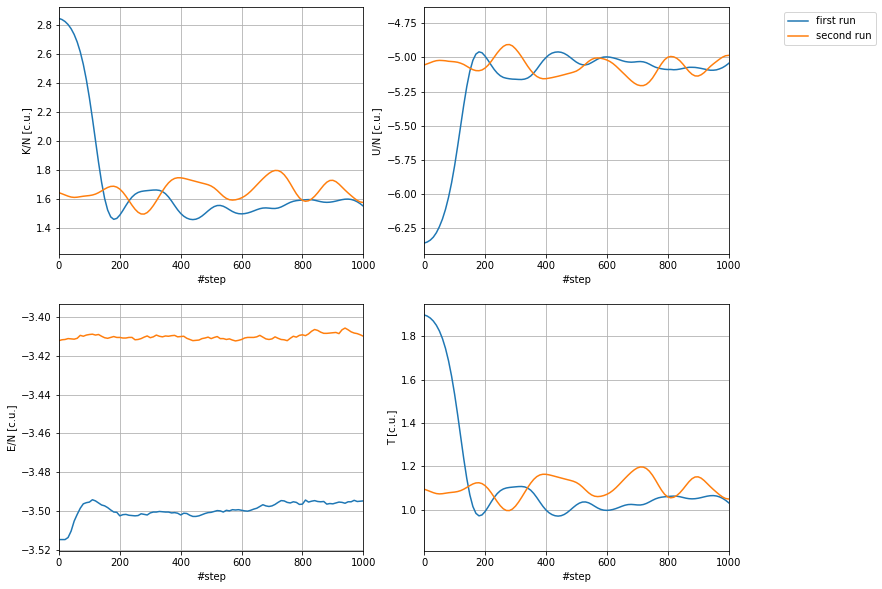

In [1]:
from IPython.display import display, Latex
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

file_in = ['output_ekin.dat', 'output_epot.dat', 'output_etot.dat', 'output_temp.dat']
labely = ['K/N [c.u.]', 'U/N [c.u.]', 'E/N [c.u.]', 'T [c.u.]']
titles = ['Energia cinetica', 'Energia potenziale', 'Energia Totale', 'Temperatura']

fr_data = [
    np.loadtxt('../04/MolecularDynamics_NVE/io_eq_fr/' + file , usecols=(0), delimiter=" ", unpack=True) for file in file_in
]

sr_data = [
    np.loadtxt('../04/MolecularDynamics_NVE/io_eq_sr/' + file , usecols=(0), delimiter=" ", unpack=True) for file in file_in
]


fig, plots = plt.subplots(2,2, gridspec_kw={'height_ratios': [2, 2]})
fig.set_size_inches(12, 10)
plots = plots.flatten()
for i in range(0, len(plots)):
    #x is the number of step, mulitply by 10
    #because measures are done very 10 steps
    x = 10*np.arange(0, len(fr_data[i]))
    plots[i].set(xlabel='#step', ylabel=labely[i])
    plots[i].grid()
    plots[i].plot(x, fr_data[i], label='first run')
    plots[i].plot(x, sr_data[i], label='second run')
    plots[i].set_xlim(0,1000)

plt.legend( bbox_to_anchor=(1.5, 2.2), loc='upper right')
plt.show()


Questi grafici sono stati focalizzati sui primi steps della simulazione. Osservando l'andamento di tutte le grandezze fisiche misurate si può osservare come nella prima esecuzione venga raggiunto l'equilibrio dopo circa 200 steps dell'algoritmo di Verlet. Utilizzando le configurazioni di simulazioni precedenti invece l'equilibrio viene raggiunto già dai primi steps.

Inoltre è interessante notare come le due simulazioni siano state eseguite con differenti temperature target. Nel caso della prima esecuzione la temperatura è stata impostata a 1.9$\epsilon/k_B$ ma nel corso della simulazione scende fino al valore di equilibrio di $(1.065 \pm 0.008) \epsilon/k_B$.
Per la seconda esecuzione viene invece impostata una temperatura target di 1.1 $\epsilon/k_B$, molto vicina a quella della simulazione precedente da cui provengono le configurazioni iniziali. In questo caso il sistema raggiunge una temperatura di equilibrio pari a $(1.086 \pm 0.002) \epsilon/k_B$. In questo modo si ottiene quindi anche una migliore accuratezza nel raggiungimento delle condizioni che vengono impostate come obiettivo della simulazione.

La differenza tra gli stati di equilibrio raggiunti nelle due simulazioni si può notare anche comparando le misure dell'energia totale che si assestano attorno a due valori leggermente differenti.

Questi risultati vengono ottenuti utilizzando temperature target per la seconda simulazione vicine a quella raggiunta nella simulazione da cui provengono i file iniziali di configurazione. In caso contrario i risultati non sono così buoni. Ad esempio i grafici seguenti sono il risultato di una simulazione avviata dalla stessa configurazione della precedente "second run" ma con temperatura target di 2.5$\epsilon/k_B$

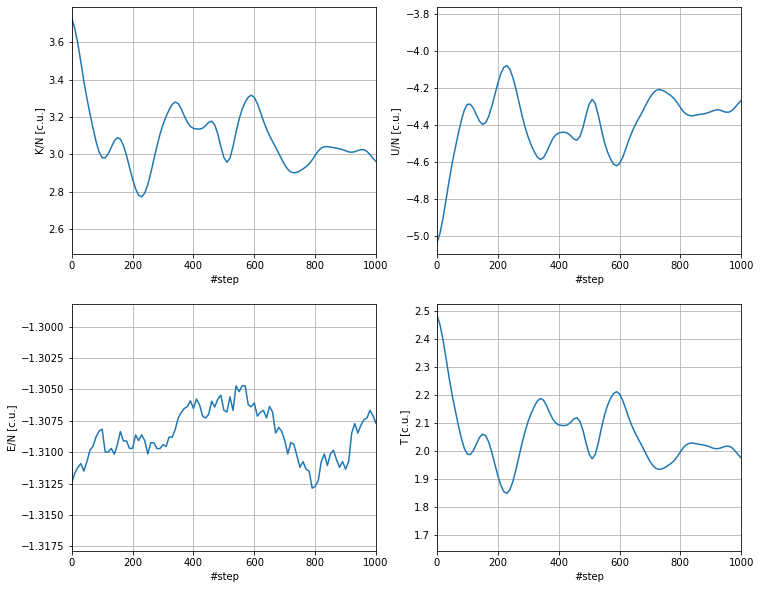

In [2]:
tr_data = [
    np.loadtxt('../04/MolecularDynamics_NVE/io_eq_tr/' + file , usecols=(0), delimiter=" ", unpack=True) for file in file_in
]

fig, plots = plt.subplots(2,2, gridspec_kw={'height_ratios': [2, 2]})
fig.set_size_inches(12, 10)
plots = plots.flatten()
for i in range(0, len(plots)):
    x = 10*np.arange(0, len(fr_data[i]))
    plots[i].set(xlabel='#step', ylabel=labely[i])
    plots[i].grid()
    plots[i].plot(x, tr_data[i])
    plots[i].set_xlim(0,1000)

plt.show()

Si nota in quest'ultimo caso la ricomparsa di una fase iniziale di equilibrazione ed una minore accuratezza nel raggiungimento della temperatura target.

## 6 Unità ridotte

Tutte le grandezze fisiche considerate nella simulazione sono espresse in unità ridotte (o unità di codice):
- $T^\star = k_BT/\epsilon$
- $U^\star = U/\epsilon$
- $K^\star = K/\epsilon$
- $E^\star = E/\epsilon$
- $P^\star = P\sigma^3/\epsilon$
- $\rho^\star = \rho\sigma^3$

$\epsilon$ e $\sigma$ sono i parametri che caratterizzano il potenziale di Lennard-Jones.
Le seguenti funzioni implementano la conversione da unità ridotte a unità del sistema internazionale, i valori di default impostati per $\epsilon$ e $\sigma$ sono quelli utilizzati nelle simulazioni che seguono.

In [3]:
import scipy.constants as cc

def CUtoSI_energy(value, epsilon=120*cc.k):
    return value*epsilon

def CUtoSI_temperature(value, epsilon=120*cc.k):
    return value*epsilon/cc.k

def CUtoSI_density(value, sigma=0.34e-9):
    return value/(sigma**3)

def CUtoSI_pressure(value, sigma=0.34e-9, epsilon=120*cc.k):
    return value*epsilon/(sigma**3)

## 7 Implementazione della media a blocchi

Le misure effettuate durante la simulazione vengono trattate con l'algoritmo della media a blocchi. Nei grafici seguenti sono mostrati i risultati ottenuti nelle stesse simulazioni dei punti precedenti. Vengono mostrate le migliori stime (medie delle medie di blocco) delle grandezze fisiche in esame, all'aumentare del numero di blocchi considerati. I grafici sono relativi alle stesse simulazioni del paragrafo 5.

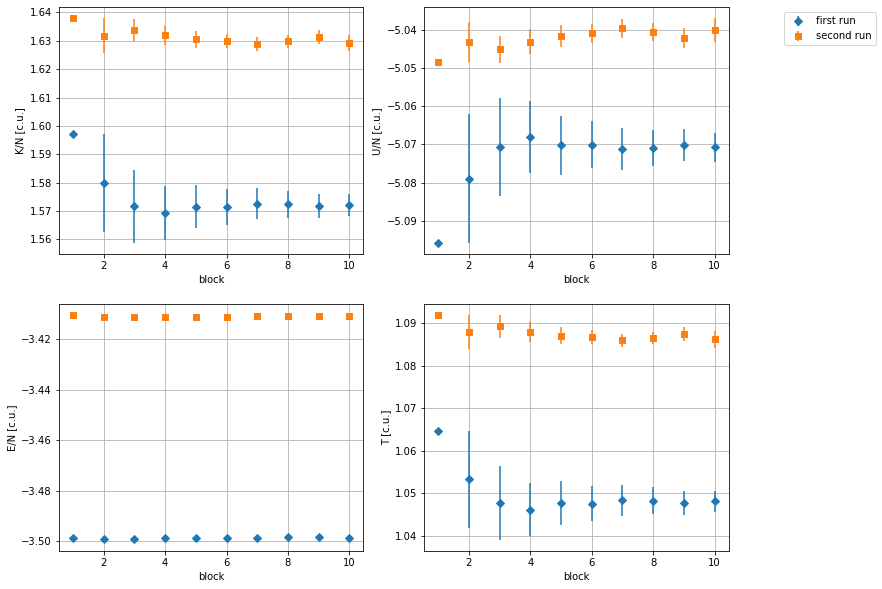

In [4]:
file_in_blk = ['output_ekin_bm.dat', 'output_epot_bm.dat', 'output_etot_bm.dat', 'output_temp_bm.dat']

fr_data = [
    np.genfromtxt('../04/MolecularDynamics_NVE/io_eq_fr/' + file , usecols=(0, 2, 3), unpack=True) for file in file_in_blk
]

sr_data = [
    np.genfromtxt('../04/MolecularDynamics_NVE/io_eq_sr/' + file , usecols=(0, 2, 3), unpack=True) for file in file_in_blk
]

figbm, plotsbm = plt.subplots(2,2, gridspec_kw={'height_ratios': [2, 2]})
figbm.set_size_inches(12, 10)
plotsbm = plotsbm.flatten()
for i in range(0, len(plots)):
    plotsbm[i].set(xlabel='block', ylabel=labely[i])
    plotsbm[i].grid()
    plotsbm[i].errorbar(fr_data[i][0], fr_data[i][1], fr_data[i][2], label='first run', fmt='D')
    plotsbm[i].errorbar(sr_data[i][0], sr_data[i][1], sr_data[i][2], label='second run', fmt='s')

plt.legend( bbox_to_anchor=(1.5, 2.2), loc='upper right')
plt.show()


In questi grafici si può osservare la progressiva diminuzione dell'incertezza statistica all'aumentare del numero di blocchi considerati. Si può inoltre apprezzare meglio, avendo una incertezza sulle misure, come le due simulazioni portino a condizioni di equilibrio differenti.

Le medie della prima simulazione sono però meno significative in quanto vengono calcolate includendo anche i valori ottenuti nella fase iniziale di equilibrazione.

## 8 Applicazioni

### 8.1 Simulazione di Argon in fase solida

Per simulare l'Argon in fase solida ho utilizzato i seguenti parametri:
$\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
corrispondenti in unità SI a $\rho = (1.857 \cdot 10^3) $kg/m$^3$, $T = 96$K.

Per eseguire la simulazione ho effettuato una prima esecuzione allo scopo di equilibrare il sistema ed ottenere una configurazione di partenza. Ho quindi eseguito una ulteriore simulazione ripartendo dalla configurazione ottenuta da quella precedente. La seconda simulazione viene eseguita a temperature vicine a quelle ottenute nella fase di equilibrio della prima, questo garantisce, come discusso in precedenza, che già dai primi steps ci si trovi in condizione di equilibrio. La temperatura target della prima simulazione è diversa dalla temperatura raggiunta poi in fase di equilibrio. Viene quindi scelta cercando, a tentativi, di ottenere alla fase di equilibrio una temepratura prossima a quella desiderata.

In questo caso le temperature in gioco sono, in unità di codice:
- temperatura target: 0.8
- temperatura target della prima simulazione: 1.5
- temperatura ottenuta nella fase di equilibrio della prima simulazione: 0.78
- temperatura ottenuta nella fase di equilibrio della seconda simulazione: 0.79

In questo modo si è riusciti a raggiungere una temperatura vicina a quella target, anche se non compatibile entro la sua incertezza statistica.

La seconda simulazione è stata eseguita per $10^4$ step dell'algoritmo di Verlet, corrispondenti a $10^3$ misure divise in 10 blocchi, per ciascuna grandezza fisica. I grafici mostrano l'evoluzione della stima delle varie grandezze fisiche all'aumentare dei blocchi considerati.

Tutte le grandezze sono riportate in unità SI corrispondenti a $\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu.

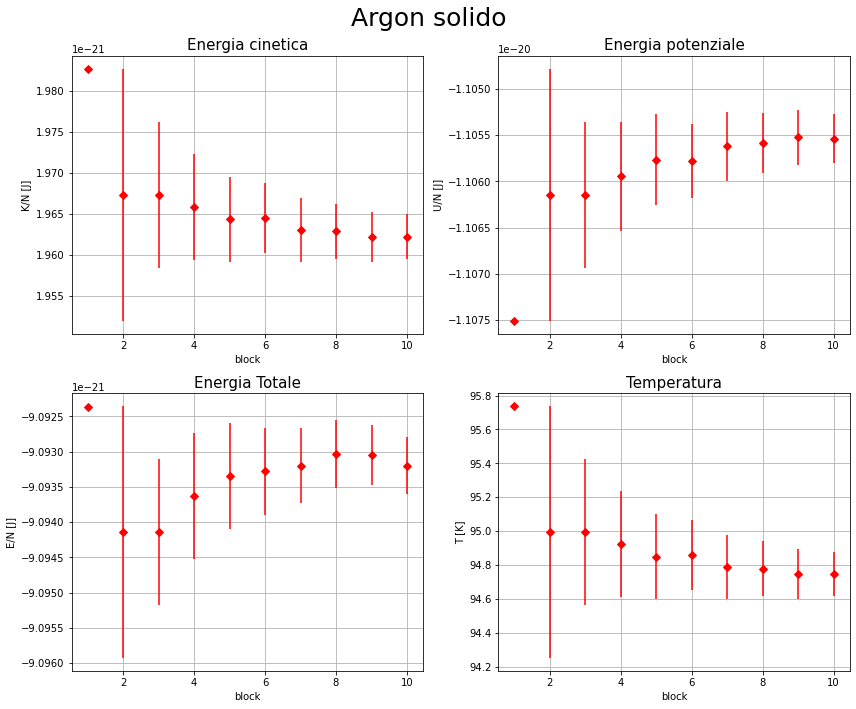

Risultati finali:
K/N = ( 1.962 ± 0.003 ) · 10^(-21) J
U/N = ( -11.055 ± 0.003 ) · 10^(-21) J
E/N = ( -9.0932 ± 0.0004 ) · 10^(-21) J
T = 94.7 ± 0.1 K


In [5]:
sol_data = [
    np.genfromtxt('../04/MolecularDynamics_NVE/ioArSolid/' + file , usecols=(0, 2, 3), unpack=True) for file in file_in_blk
]

labely = ['K/N [J]', 'U/N [J]', 'E/N [J]', 'T [K]']

CUtoSI = [CUtoSI_energy(1), CUtoSI_energy(1), CUtoSI_energy(1), CUtoSI_temperature(1)]

figbm, plotsbm = plt.subplots(2,2, gridspec_kw={'height_ratios': [2, 2]})
figbm.set_size_inches(12, 10)
plotsbm = plotsbm.flatten()
for i in range(0, len(plots)):
    plotsbm[i].set(xlabel='block', ylabel=labely[i])
    plotsbm[i].grid()
    plotsbm[i].set_title(titles[i], fontsize='15')
    plotsbm[i].errorbar(sol_data[i][0], CUtoSI[i]*sol_data[i][1], CUtoSI[i]*sol_data[i][2], fmt='D', color='red')

figbm.suptitle('Argon solido', fontsize='25')
figbm.tight_layout()
plt.show()

print('Risultati finali:')
print('K/N = ( {:.4} ± {:.1} ) · 10^(-21) J'.format(CUtoSI_energy(sol_data[0][1][-1])*1e21, CUtoSI_energy(sol_data[0][2][-1])*1e21))
print('U/N = ( {:.5} ± {:.1} ) · 10^(-21) J'.format(CUtoSI_energy(sol_data[1][1][-1])*1e21, CUtoSI_energy(sol_data[1][2][-1])*1e21))
print('E/N = ( {:.5} ± {:.1} ) · 10^(-21) J'.format(CUtoSI_energy(sol_data[2][1][-1])*1e21, CUtoSI_energy(sol_data[2][2][-1])*1e21))
print('T = {:.3} ± {:.1} K'.format(CUtoSI_temperature(sol_data[3][1][-1]), CUtoSI_temperature(sol_data[3][2][-1])))

### 8.2 Simulazione di Argon in fase liquida

Per la simulazione della fase liquida  ho utilizzato i seguenti parametri: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$), corrispondenti in unità SI a $\rho = (1.350 \cdot 10^3) $kg/m$^3$, $T = 132$K.

Il metodo con cui è stata eseguita la simulazione è lo stesso del caso precedente. Identici sono anche il numero di step, blocchi e misure utilizzati.

In questo caso le temperature in gioco sono, in unità di codice, le seguenti:
- temperatura target: 1.1
- temperatura target della prima simulazione: 2.0
- temperatura ottenuta nella fase di equilibrio della prima simulazione: 1.11
- temperatura ottenuta nella fase di equilibrio della seconda simulazione: 1.06

Anche in questo caso si è riusciti ad ottenere una temperatura simile a quella target anche se non compatibile considerandone l'incertezza.

I risultati sono quelli nella figura seguente.

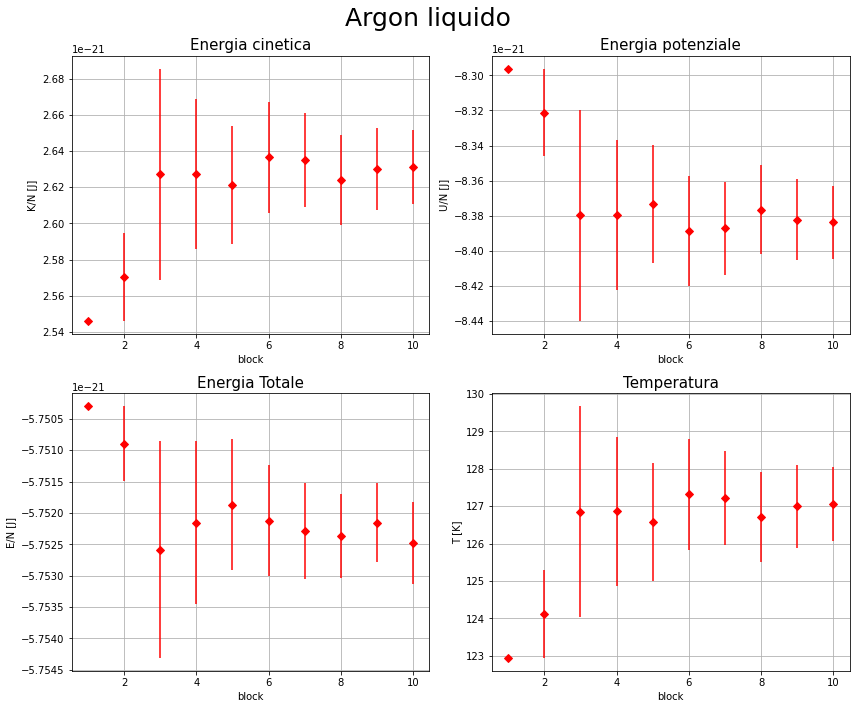

Risultati finali:
K/N = ( 2.631 ± 0.02 ) · 10^(-21) J
V/N = ( -8.38 ± 0.02 ) · 10^(-21) J
E/N = ( -5.7525 ± 0.0007 ) · 10^(-21) J
T = 127.1 ± 1.0 K


In [6]:
liq_data = [
    np.genfromtxt('../04/MolecularDynamics_NVE/ioArLiquid/' + file , usecols=(0, 2, 3), unpack=True) for file in file_in_blk
]

figbm, plotsbm = plt.subplots(2,2, gridspec_kw={'height_ratios': [2, 2]})
figbm.set_size_inches(12, 10)
plotsbm = plotsbm.flatten()
for i in range(0, len(plots)):
    plotsbm[i].set(xlabel='block', ylabel=labely[i])
    plotsbm[i].grid()
    plotsbm[i].set_title(titles[i], fontsize='15')
    plotsbm[i].errorbar(liq_data[i][0], CUtoSI[i]*liq_data[i][1], CUtoSI[i]*liq_data[i][2], fmt='D', color='red')

figbm.suptitle('Argon liquido', fontsize='25')
figbm.tight_layout()

plt.show()

print('Risultati finali:')
print('K/N = ( {:.4} ± {:.1} ) · 10^(-21) J'.format(CUtoSI_energy(liq_data[0][1][-1])*1e21, CUtoSI_energy(liq_data[0][2][-1])*1e21))
print('V/N = ( {:.3} ± {:.1} ) · 10^(-21) J'.format(CUtoSI_energy(liq_data[1][1][-1])*1e21, CUtoSI_energy(liq_data[1][2][-1])*1e21))
print('E/N = ( {:.5} ± {:.1} ) · 10^(-21) J'.format(CUtoSI_energy(liq_data[2][1][-1])*1e21, CUtoSI_energy(liq_data[2][2][-1])*1e21))
print('T = {:.1f} ± {:.1f} K'.format(CUtoSI_temperature(liq_data[3][1][-1]), CUtoSI_temperature(liq_data[3][2][-1])))

### 8.3 Simulazione di Argon in fase gassosa

Per la simulazione della fase gassosa  ho utilizzato i seguenti parametri: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$), corrispondenti in unità SI a $\rho = (0.844 \cdot 10^3) $kg/m$^3$, $T = 144$K.

Il metodo con cui è stata eseguita la simulazione è lo stesso dei caso precedenti così come il numero di step, blocchi e misure utilizzati.

In questo caso le temperature in gioco sono, in unità di codice, le seguenti:
- temperatura target: 1.2
- temperatura target della prima simulazione: 1.0
- temperatura ottenuta nella fase di equilibrio della prima simulazione: 1.24
- temperatura ottenuta nella fase di equilibrio della seconda simulazione: 1.24

Anche in questo caso si è riusciti ad ottenere una temperatura simile a quella target anche se non compatibile considerandone l'incertezza.

I risultati sono quelli nella figura seguente.

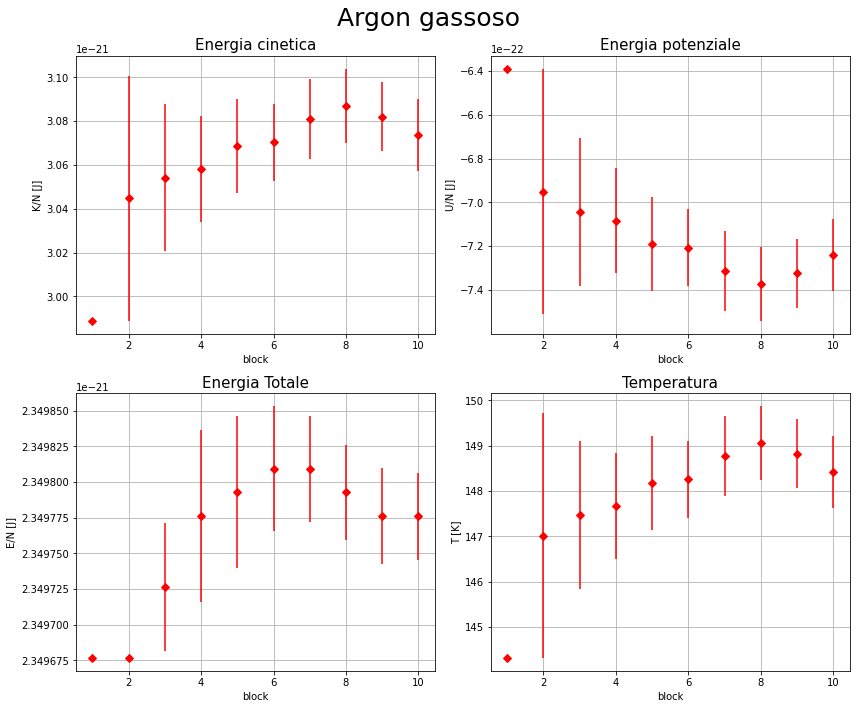

Risultati finali:
K/N = ( 3.07 ± 0.02 ) · 10^(-21) J
V/N = ( -0.72 ± 0.02 ) · 10^(-21) J
E/N = ( 2.34978 ± 0.00003 ) · 10^(-21) J
T = 148.4 ± 0.8 K


In [7]:
gas_data = [
    np.genfromtxt('../04/MolecularDynamics_NVE/ioArGas/' + file , usecols=(0, 2, 3), unpack=True) for file in file_in_blk
]

figbm, plotsbm = plt.subplots(2,2, gridspec_kw={'height_ratios': [2, 2]})
figbm.set_size_inches(12, 10)
plotsbm = plotsbm.flatten()
for i in range(0, len(plots)):
    plotsbm[i].set(xlabel='block', ylabel=labely[i])
    plotsbm[i].grid()
    plotsbm[i].set_title(titles[i], fontsize='15')
    plotsbm[i].errorbar(gas_data[i][0], CUtoSI[i]*gas_data[i][1], CUtoSI[i]*gas_data[i][2], fmt='D', color='red')
    plotsbm[i].ticklabel_format(useOffset=False)
    
figbm.suptitle('Argon gassoso', fontsize='25')
figbm.tight_layout()

plt.show()

print('Risultati finali:')
print('K/N = ( {:.3} ± {:.1} ) · 10^(-21) J'.format(CUtoSI_energy(gas_data[0][1][-1])*1e21, CUtoSI_energy(gas_data[0][2][-1])*1e21))
print('V/N = ( {:.2} ± {:.1} ) · 10^(-21) J'.format(CUtoSI_energy(gas_data[1][1][-1])*1e21, CUtoSI_energy(gas_data[1][2][-1])*1e21))
print('E/N = ( {:.6} ± {:.5f} ) · 10^(-21) J'.format(CUtoSI_energy(gas_data[2][1][-1])*1e21, CUtoSI_energy(gas_data[2][2][-1])*1e21))
print('T = {:.1f} ± {:.1f} K'.format(CUtoSI_temperature(gas_data[3][1][-1]), CUtoSI_temperature(gas_data[3][2][-1])))

## 9 Pressione

Ho aggiunto al codice anche il calcolo della pressione, determinata utilizzando la seguente relazione ottenuta dal teorema del viriale:

$$
 P = \rho k_B T + \frac{1}{3V} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 48\epsilon \left[ \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - 
\frac{1}{2} \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^6 \right] \right\rangle
$$

Aggiungo la seguente funzione per passare dalle unità ridotte alle unità SI

In [8]:
def CUtoSI_press(value, sigma=0.34e-9, epsilon=120*cc.k):
    return value*epsilon/(sigma**3)

I risultati ottenuti per i 3 stati sono mostrati nel grafico successivo. Questo calcolo è stato introdotto per poter confrontare questi risultati con quelli ottenuti nell'esercitazione 7, in cui viene simulato un sistema analogo con un metodo diverso.

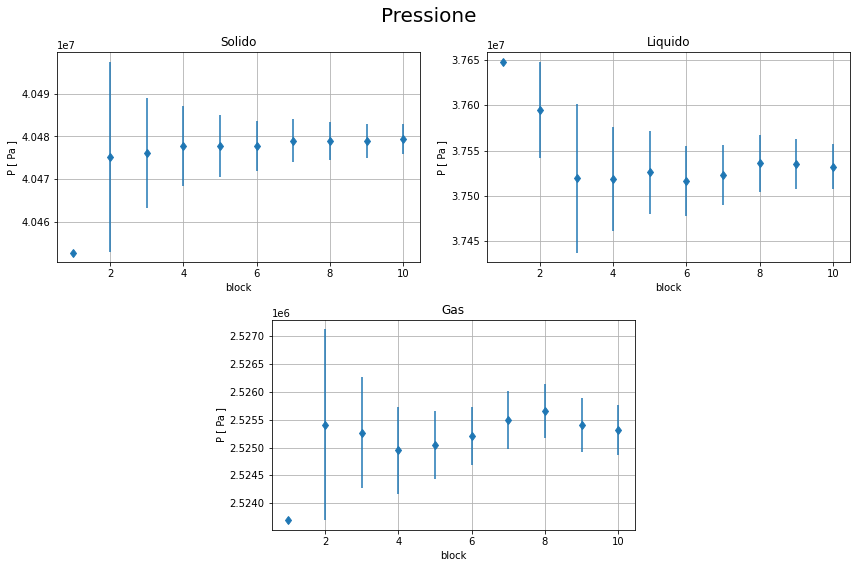

Stime finali ottenute
Solido	: (4.04793e+07 ± 3.53e+03) Pa
Liquido	: (3.75324e+07 ± 2.48e+04) Pa
Gas	: (2.52532e+06 ± 4.48e+02) Pa


In [9]:
import matplotlib.gridspec as grid
files = ['../04/MolecularDynamics_NVE/ioArSolid/output_pres_bm.dat', 
         '../04/MolecularDynamics_NVE/ioArLiquid/output_pres_bm.dat',
         '../04/MolecularDynamics_NVE/ioArGas/output_pres_bm.dat']
titles = ['Solido', 'Liquido', 'Gas']
#fig, plots = plt.subplots(2,2)
gs = grid.GridSpec(2,4)
fig = plt.figure()
plots = [plt.subplot(gs[0,0:2]), plt.subplot(gs[0,2:4]), plt.subplot(gs[1,1:3])]
fig.set_size_inches(12, 8)
#plots = plots.flatten()

finals=[]
for i  in range(0, len(files)):
    r, val, err = np.genfromtxt(files[i], usecols=(0,2,3), unpack=True)
    plots[i].errorbar(r, CUtoSI_press(val), CUtoSI_press(err), fmt='d')
    plots[i].set_title(titles[i])
    plots[i].set_xlabel('block')
    plots[i].set_ylabel('P [ Pa ]')
    plots[i].grid()
    finals.append((CUtoSI_press(val[-1]), CUtoSI_press(err[-1])))
                      
plt.suptitle('Pressione', fontsize='20')
plt.tight_layout()
plt.show()

print('Stime finali ottenute')
for i in range(len(titles)):
    print(titles[i] + '\t: ({:.5e} ± {:.2e}) Pa'.format(finals[i][0], finals[i][1]))